In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import utilix
import numpy as np
from tqdm import tqdm
import os
path_start = '/dali/lgrandi/rucio/xnt_'

In [2]:
sr0_right = 34731
sr0_left  = 17918
sr1_left  = 43039
sr1_right = 53000

In [3]:
def find_with_mode(rules, runs, mode):
    is_mode = np.zeros(len(rules), np.bool)
    for i,r in enumerate(rules):
        if int(r['runid'])<50126:
            if runs[int(r['runid'])]['mode'] == mode:
                is_mode[i] = True
    print(np.sum(is_mode))
    return rules[is_mode]

def size_vs_runs(rules, runid_min=0, runid_max=50200, nbins=100):
    runids = rules['runid'].astype(np.int32)
    bins_bound = np.linspace(runid_min, runid_max, nbins+1)
    sizes_tb = np.zeros(nbins)
    for b in range(nbins):
        selected_mask = runids>=bins_bound[b]
        selected_mask &= runids<=bins_bound[b+1]
        rules_selected = rules[selected_mask]
        if len(rules_selected):
            sizes_tb[b] = np.sum(rules_selected['size_gb']/1024)
    
    cum_sizes_tb = np.cumsum(sizes_tb)
    return cum_sizes_tb

def find_with_tags(rules, runs, tags):
    tagged = np.zeros(len(rules), np.bool)
    for i,r in enumerate(rules):
        for t in tags:
            if runs[int(r['runid'])][t]:
                tagged[i] = True
    print(np.sum(tagged))
    return rules[tagged]

def filter_out_rad(rules, runs):
    is_rad = np.zeros(len(rules), np.bool)
    for i,r in enumerate(rules):
        if runs[int(r['runid'])]['RAD_commissioning']:
            is_rad[i] = True
    return rules[~is_rad]

In [4]:
import pymongo
from utilix import xent_collection
coll = xent_collection()

runs_dtype = np.dtype([('number', np.int32), 
                       ('mode', 'O'),
                       ('bad', np.bool),
                       ('messy', np.bool),
                       ('hot_spot', np.bool),
                       ('ramp_down', np.bool),
                       ('ramp_up', np.bool),
                       ('pmt_trip', np.bool),
                       ('rn220_fast_alphas', np.bool),
                       ('after_rn220', np.bool),
                       ('abandon', np.bool),
                       ('RAD_commissioning', np.bool)])
runs = np.zeros(sr1_right, dtype = runs_dtype)

for i in tqdm(range(sr1_right)):
    query = {'number': i}
    doc = coll.find_one(query)
    runs[i]['number'] = i
    runs[i]['mode'] = doc['mode']
    try:
        tags = doc['tags']
        for t in tags:
            if t['name'] == 'bad':
                runs[i]['bad'] = True
            elif t['name'] == 'messy':
                runs[i]['messy'] = True
            elif t['name'] == 'hot_spot':
                runs[i]['hot_spot'] = True
            elif t['name'] == 'ramp_down':
                runs[i]['ramp_down'] = True
            elif t['name'] == 'ramp_up':
                runs[i]['ramp_up'] = True            
            elif t['name'] == 'pmt_trip':
                runs[i]['pmt_trip'] = True
            elif t['name'] == 'rn220_fast_alphas':
                runs[i]['rn220_fast_alphas'] = True
            elif t['name'] == 'after_rn220':
                runs[i]['after_rn220'] = True
            elif t['name'] == 'abandon':
                runs[i]['abandon'] = True
            elif t['name'] == 'RAD_commissioning':
                runs[i]['RAD_commissioning'] = True
    except:
        pass

/tmp/jobs/28626149/ipykernel_198/3704770957.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ('bad', np.bool),
/tmp/jobs/28626149/ipykernel_198/3704770957.py:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ('messy', np.bool),
/tmp/jobs/28626149/ipykernel_198/3704770957.py:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `b

In [5]:
for i in range(20):
    if i == 0:
        rules_info = np.load('/project2/lgrandi/yuanlq/shared/dali_cleanup/rucio_20230628_all_rules0.npy', 
                             allow_pickle=True)
    else:
        new = np.load('/project2/lgrandi/yuanlq/shared/dali_cleanup/rucio_20230628_all_rules%s.npy'%(i), 
                      allow_pickle=True)
        rules_info = np.concatenate((rules_info, new))

In [6]:
rules_info = rules_info[rules_info['UC_DALI_USERDISK']]

In [7]:
rules_info = rules_info[rules_info['runid'].astype(int)<sr1_right]
rules_info_norad = filter_out_rad(rules=rules_info, runs=runs)

/tmp/jobs/28626149/ipykernel_198/1901956045.py:34: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_rad = np.zeros(len(rules), np.bool)


In [8]:
size_all = rules_info['size_gb'].sum()
print('All rucio data on dali: %sTB'%(int(size_all/1024)))

All rucio data on dali: 183TB


In [9]:
size_peaklets = rules_info['size_gb'][rules_info['data_type']=='peaklets'].sum()
print('All peaklets on dali: %sTB'%(int(size_peaklets/1024)))

All peaklets on dali: 111TB


In [10]:
size_hitlets_nv = rules_info['size_gb'][rules_info['data_type']=='hitlets_nv'].sum()
print('All hitlets_nv on dali: %sTB'%(int(size_hitlets_nv/1024)))

All hitlets_nv on dali: 18TB


In [11]:
size_merged_s2s = rules_info['size_gb'][rules_info['data_type']=='merged_s2s'].sum()
print('All merged_s2s on dali: %sTB'%(int(size_merged_s2s/1024)))

All merged_s2s on dali: 25TB


In [12]:
all_dtypes = np.unique(rules_info['data_type'])
names = []
sizes_gb = []
for dt in all_dtypes:
    selected = rules_info[rules_info['data_type']==dt]
    names.append(dt)
    sizes_gb.append(selected['size_gb'].sum())
names = np.array(names)
sizes_gb = np.array(sizes_gb)
argsort = sizes_gb.argsort()
names_sort = names[argsort]
sizes_gb_sort = sizes_gb[argsort]
for i in range(len(names)):
    if int(sizes_gb_sort[i]/1024) >= 1:
        print(names_sort[i], int(sizes_gb_sort[i]/1024), 'TB')

afterpulses 1 TB
peaklet_classification 1 TB
peak_proximity 1 TB
led_calibration 2 TB
events_nv 2 TB
peak_basics 3 TB
lone_hits 8 TB
hitlets_nv 18 TB
merged_s2s 25 TB
peaklets 111 TB


In [13]:
cum_sizes_tb_pkl = size_vs_runs(rules_info_norad[rules_info_norad['data_type']=='peaklets'])
cum_sizes_tb_hnv = size_vs_runs(rules_info_norad[rules_info_norad['data_type']=='hitlets_nv'])
cum_sizes_tb_ms2 = size_vs_runs(rules_info_norad[rules_info_norad['data_type']=='merged_s2s'])

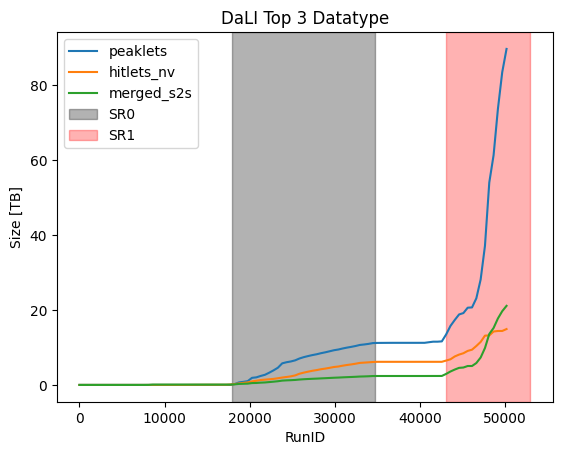

In [15]:
plt.figure(dpi=100)
plt.plot(np.linspace(0, 50200, 100), cum_sizes_tb_pkl, label='peaklets')
plt.plot(np.linspace(0, 50200, 100), cum_sizes_tb_hnv, label='hitlets_nv')
plt.plot(np.linspace(0, 50200, 100), cum_sizes_tb_ms2, label='merged_s2s')

plt.xlabel('RunID')
plt.title('DaLI Top 3 Datatype')
plt.ylabel('Size [TB]')
plt.axvspan(sr0_left, sr0_right, alpha=0.3, color='k', label='SR0')
plt.axvspan(sr1_left, sr1_right, alpha=0.3, color='r', label='SR1')
#plt.yscale('log')
#plt.gca().set_ylim(top=80)
plt.legend()

In [16]:
import cutax
st = cutax.contexts.xenonnt_online()
all_runs = st.select_runs()
modes = set(all_runs["mode"])
modes_list = list(modes)

You specified _auto_append_rucio_local=True and you are not on dali compute nodes,so we will add the following rucio local path:  /project/lgrandi/rucio/


Checking data availability: 0it [00:00, ?it/s]

Checking data availability:   0%|          | 0/2 [00:00<?, ?it/s]

/cvmfs/xenon.opensciencegrid.org/releases/nT/development/anaconda/envs/XENONnT_development/lib/python3.9/site-packages/straxen/url_config.py:707: FutureWarning: From straxen version 2.1.0 onward, URLConfig parameters will be sorted alphabetically before being passed to the plugins, this will change the lineage hash for non-sorted URLs. To load data processed with non-sorted URLs, you will need to use an older version.
  warnings.warn("From straxen version 2.1.0 onward, URLConfig parameters will be sorted alphabetically before being passed to the plugins, this will change the lineage hash for non-sorted URLs. To load data processed with non-sorted URLs, you will need to use an older version.", FutureWarning)


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


1369


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


4104


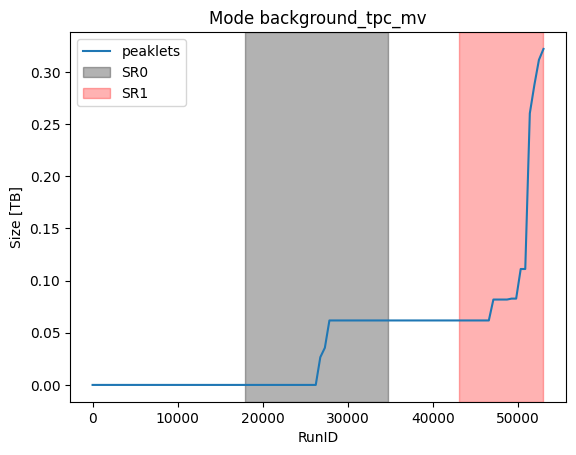

/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


1


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)
/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


2
1351


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


36


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


18


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


3


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


10499


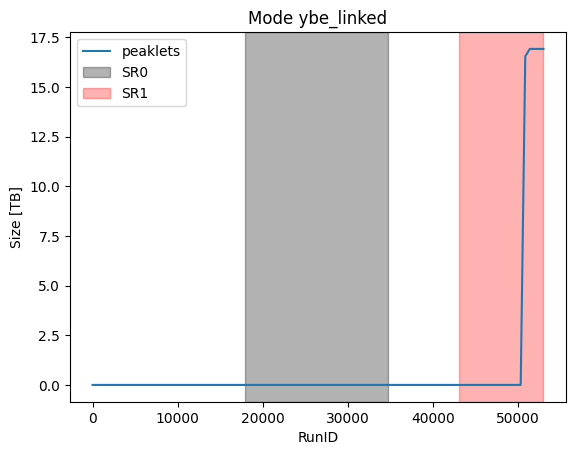

/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


445


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


0


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


362


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


16


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


957


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


24


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


0


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


131


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


33


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)
/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


1
74


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


2


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


44


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


30


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


170


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


28315


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


217


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


100


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


2

/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)



22


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


587


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


36835


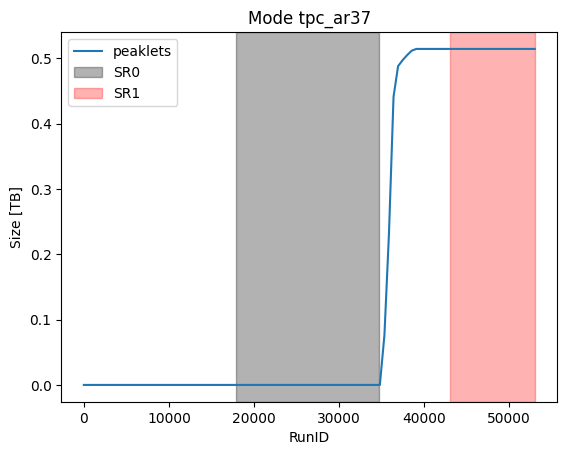

/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


407


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


438


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


0


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


2491


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


3


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)
/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


543
301


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


1


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


36705


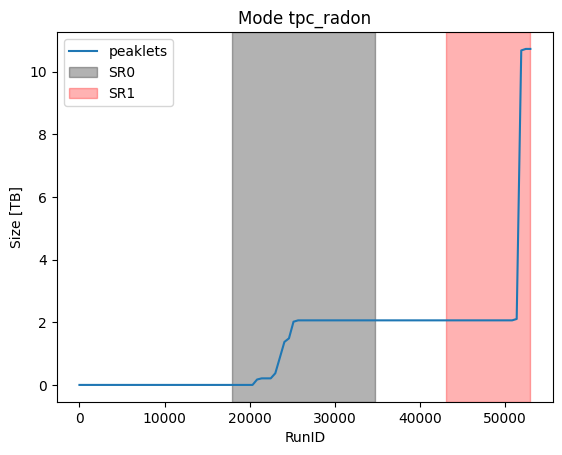

/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


1


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


5896


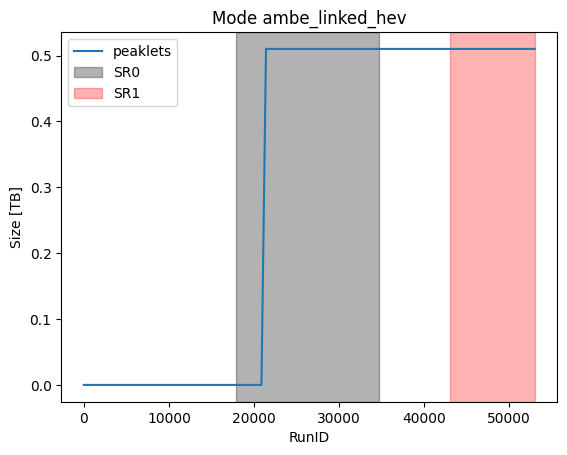

/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


7


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


3640


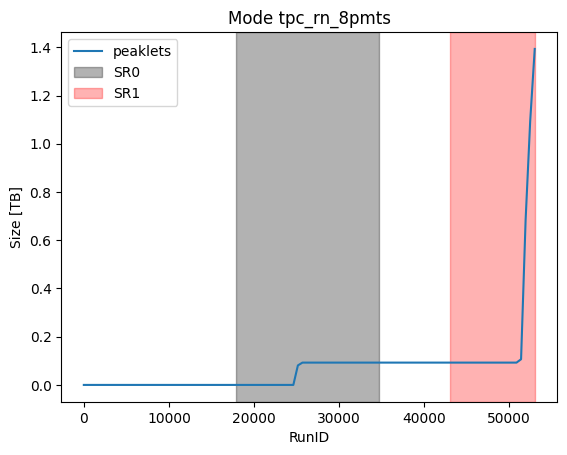

/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


0


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


47


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


3


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


1


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


1


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


0


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


13311


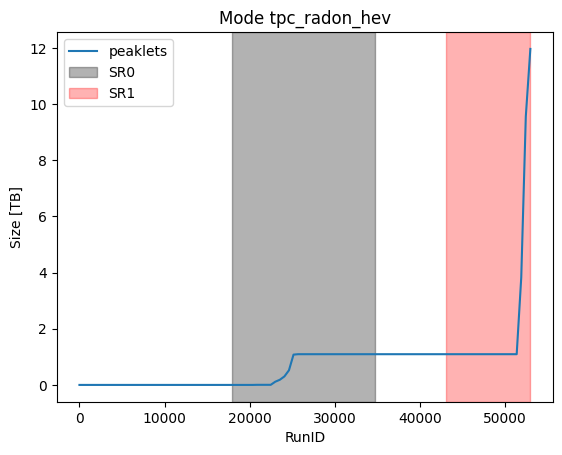

/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


321


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


2683


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


25


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


87


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


32


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


1


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


0


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


162


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


5


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


58


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


10


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


452


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


1


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


575


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


0


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


311


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


20991


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


10858


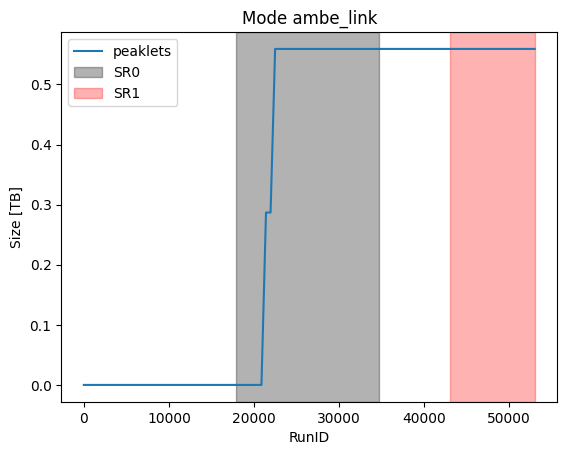

/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


1631


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


29715


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


337


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


394


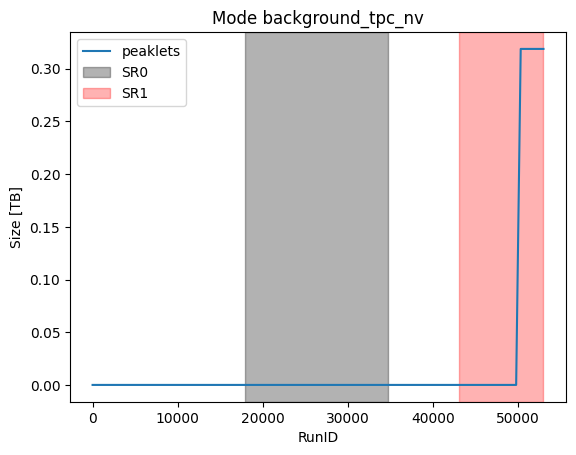

/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


0


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


20


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


393631


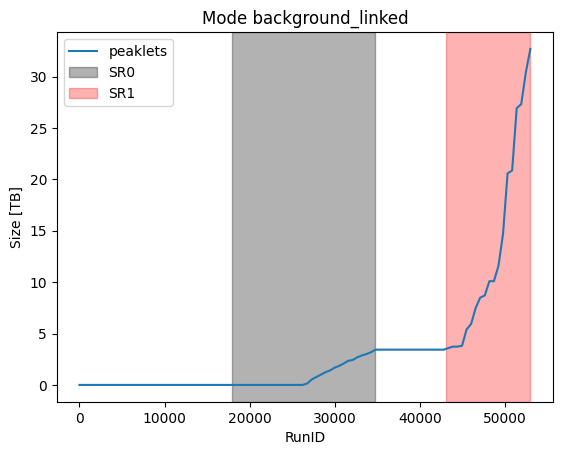

/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


3517


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


2


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)
/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


0
0


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


54654


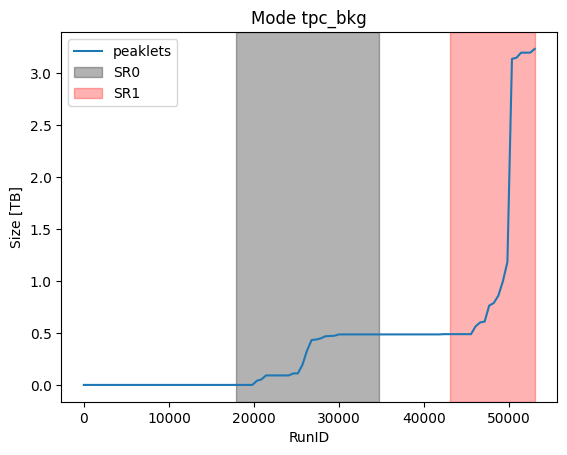

/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


762


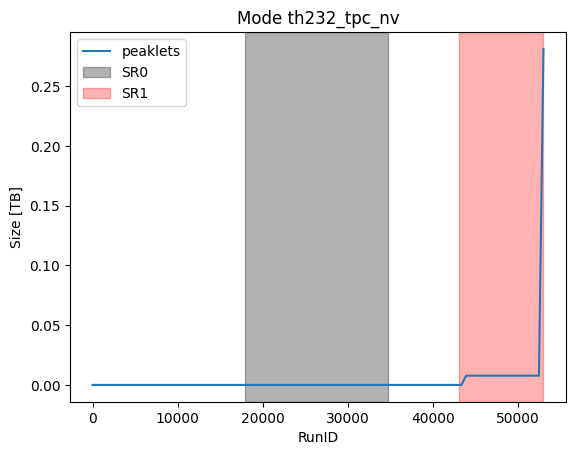

/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


0


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


0


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


0


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


6


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


108856


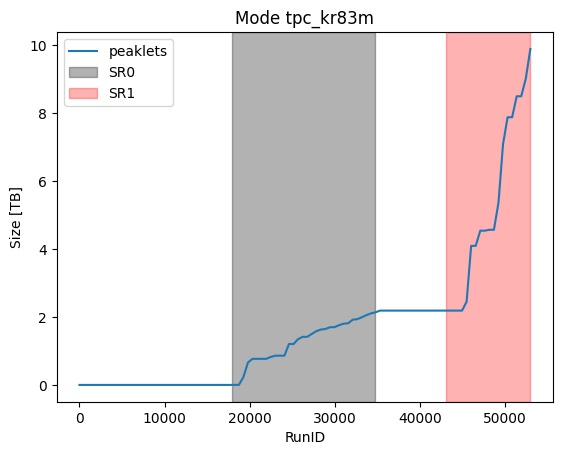

/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


727


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


288


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


75


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


0
tpc_rn_8pmts 1 TB
tpc_bkg 3 TB
tpc_kr83m 9 TB
tpc_radon 10 TB
tpc_radon_hev 11 TB
ybe_linked 16 TB
background_linked 32 TB


In [17]:
total_pkl = 0

size_pkl = []

for m in modes_list:
    rules_info_mode = find_with_mode(rules=rules_info_norad, runs=runs, mode=m)
    cum_sizes_tb_pkl_mode = size_vs_runs(rules_info_mode[(rules_info_mode['data_type']=='peaklets')])
        
    total_pkl += cum_sizes_tb_pkl_mode[-1]
    
    size_pkl.append(int(cum_sizes_tb_pkl_mode[-1]))
    
    if cum_sizes_tb_pkl_mode[-1] > 0.2: 
    
        plt.figure(dpi=100)
        plt.plot(np.linspace(0, sr1_right, 100), cum_sizes_tb_pkl_mode, label='peaklets')
        plt.xlabel('RunID')
        plt.title('Mode %s'%(m))
        plt.ylabel('Size [TB]')
        plt.axvspan(sr0_left, sr0_right, alpha=0.3, color='k', label='SR0')
        plt.axvspan(sr1_left, sr1_right, alpha=0.3, color='r', label='SR1')
        #plt.yscale('log')
        #plt.gca().set_ylim(bottom=1)
        plt.legend()
        plt.savefig('osg_straxdata_mode_%s'%(m))
        plt.show()

size_pkl = np.array(size_pkl)   

modes_list = np.array(modes_list)

for i in range(len(modes_list)):
    if size_pkl[size_pkl.argsort()][i] > 0.2:
        print(modes_list[size_pkl.argsort()][i], size_pkl[size_pkl.argsort()][i], 'TB')

/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


1369


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


4104


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


1


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


2


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


1351


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


36


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


18


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


3


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


10499


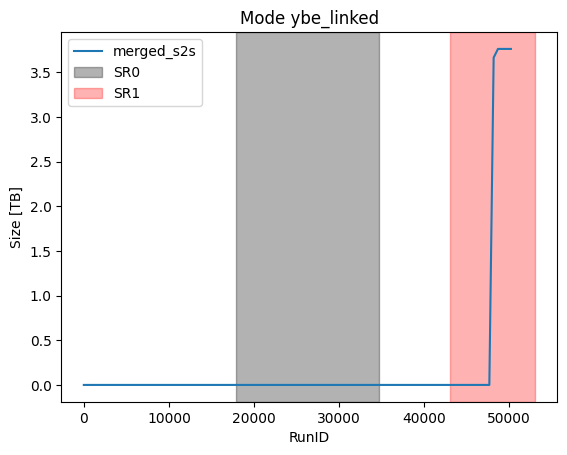

/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


445


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


0


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


362


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


16


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


957


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


24


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


0


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


131


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


33


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


1


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


74


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)
/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


2
44


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


30


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


170


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


28315


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


217


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


100


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)
/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


2
22


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


587


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


36835


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


407


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


438


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


0


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


2491


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


3


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


543


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


301


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


1


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


36705


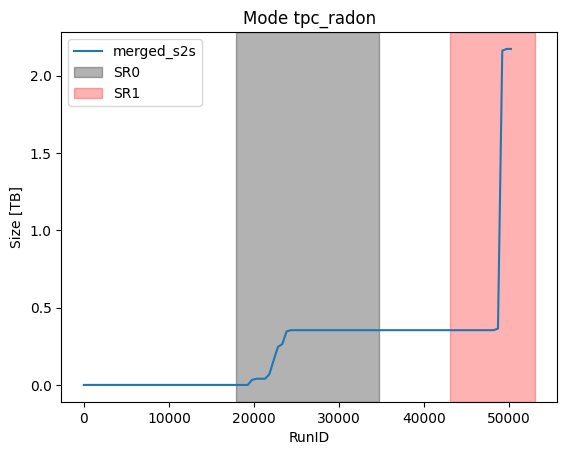

/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


1


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


5896


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


7


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


3640


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


0


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


47


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


3


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)
/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


1
1


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


0


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


13311


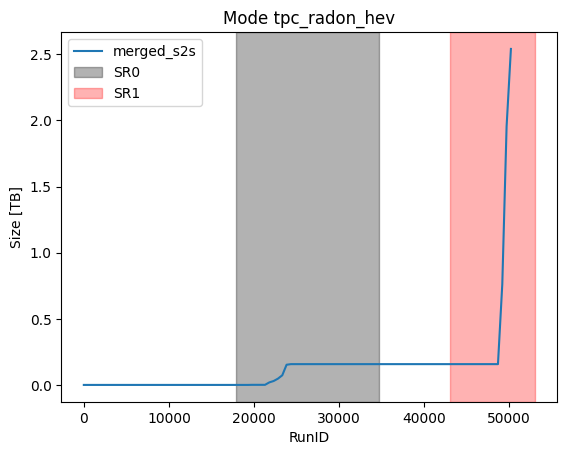

/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


321


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


2683


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


25


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


87


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


32


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


1


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


0


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


162


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


5


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


58


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


10


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


452


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


1


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


575


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


0


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


311


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


20991


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


10858


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


1631


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


29715


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


337


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


394


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


0


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


20


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


393631


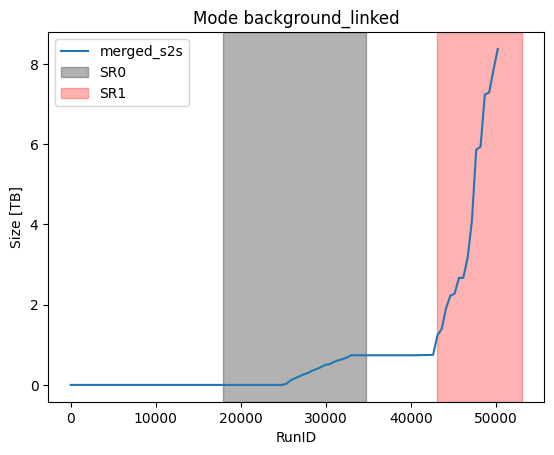

/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


3517


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


2


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


0


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


0


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


54654


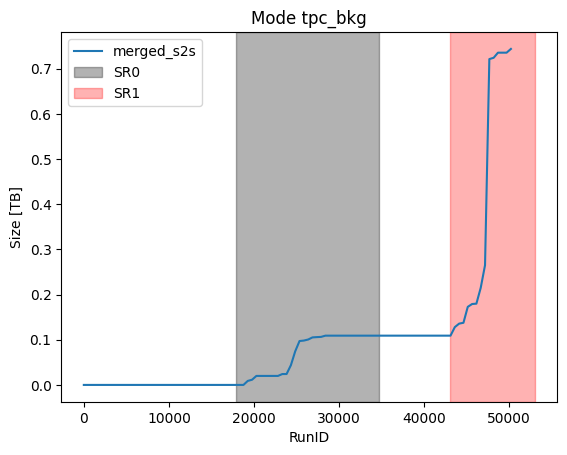

/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


762


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


0


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


0


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


0


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


6


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


108856


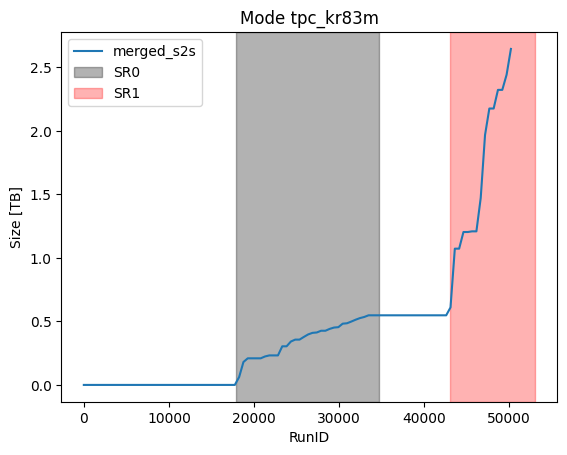

/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


727


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


288


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


75


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


0
tpc_radon_hev 2 TB
tpc_radon 2 TB
tpc_kr83m 2 TB
ybe_linked 3 TB
background_linked 8 TB


In [18]:
total_ms2 = 0

size_ms2 = []

for m in modes_list:
    rules_info_mode = find_with_mode(rules=rules_info_norad, runs=runs, mode=m)
    cum_sizes_tb_ms2_mode = size_vs_runs(rules_info_mode[(rules_info_mode['data_type']=='merged_s2s')])
        
    total_ms2 += cum_sizes_tb_ms2_mode[-1]
    
    size_ms2.append(int(cum_sizes_tb_ms2_mode[-1]))
    
    if cum_sizes_tb_ms2_mode[-1] > 0.2: 
    
        plt.figure(dpi=100)
        plt.plot(np.linspace(0, 50200, 100), cum_sizes_tb_ms2_mode, label='merged_s2s')
        plt.xlabel('RunID')
        plt.title('Mode %s'%(m))
        plt.ylabel('Size [TB]')
        plt.axvspan(sr0_left, sr0_right, alpha=0.3, color='k', label='SR0')
        plt.axvspan(sr1_left, sr1_right, alpha=0.3, color='r', label='SR1')
        #plt.yscale('log')
        #plt.gca().set_ylim(bottom=1)
        plt.legend()
        plt.savefig('osg_straxdata_mode_%s'%(m))
        plt.show()

size_ms2 = np.array(size_ms2)   

modes_list = np.array(modes_list)

for i in range(len(modes_list)):
    if size_ms2[size_ms2.argsort()][i] > 0.2:
        print(modes_list[size_ms2.argsort()][i], size_ms2[size_ms2.argsort()][i], 'TB')

/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


1369


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


4104


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


1


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


2


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


1351


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


36


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


18


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


3


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


10499


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


445


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


0


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


362


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


16


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


957


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


24


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


0


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


131


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


33


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


1


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


74


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


2


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


44


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


30


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


170


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


28315


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


217


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


100


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


2


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


22


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


587


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


36835


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


407


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


438


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


0


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


2491


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)
/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


3
543


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


301


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


1


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


36705


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


1


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


5896


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


7


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


3640


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)
/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


0


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


47
3


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


1


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


1


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


0


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


13311


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


321


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


2683


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


25


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


87


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


32


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


1


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)
/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


0
162


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


5


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


58


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


10


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


452


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


1


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


575


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


0


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


311


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


20991


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


10858


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


1631


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


29715


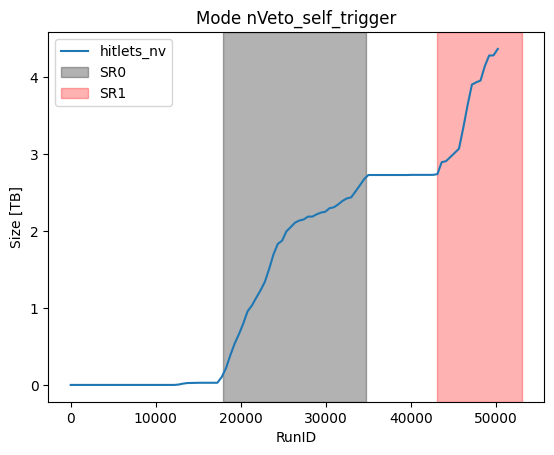

/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


337


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


394


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


0


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


20


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


393631


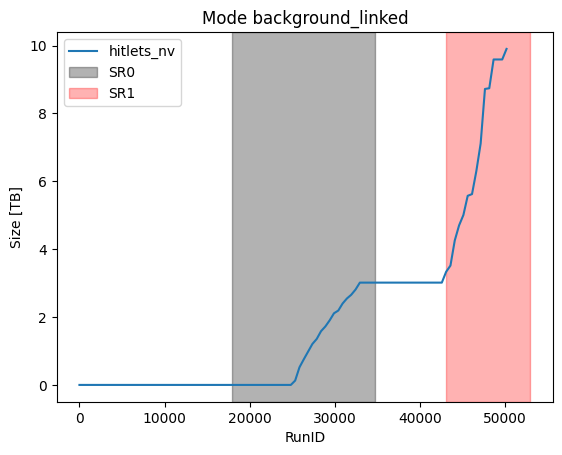

/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


3517


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


2


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


0


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


0


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


54654


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


762


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


0


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


0


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


0


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


6


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


108856


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


727


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


288


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


75


/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


0
nVeto_self_trigger 4 TB
background_linked 9 TB


In [19]:
total_rrnv = 0

size_rrnv = []

for m in modes_list:
    rules_info_mode = find_with_mode(rules=rules_info_norad, runs=runs, mode=m)
    cum_sizes_tb_rrnv_mode = size_vs_runs(rules_info_mode[(rules_info_mode['data_type']=='hitlets_nv')])
        
    total_rrnv += cum_sizes_tb_rrnv_mode[-1]
    
    size_rrnv.append(int(cum_sizes_tb_rrnv_mode[-1]))
    
    if cum_sizes_tb_rrnv_mode[-1] > 0.2: 
    
        plt.figure(dpi=100)
        plt.plot(np.linspace(0, 50200, 100), cum_sizes_tb_rrnv_mode, label='hitlets_nv')
        plt.xlabel('RunID')
        plt.title('Mode %s'%(m))
        plt.ylabel('Size [TB]')
        plt.axvspan(sr0_left, sr0_right, alpha=0.3, color='k', label='SR0')
        plt.axvspan(sr1_left, sr1_right, alpha=0.3, color='r', label='SR1')
        #plt.yscale('log')
        #plt.gca().set_ylim(bottom=1)
        plt.legend()
        plt.savefig('osg_straxdata_mode_%s'%(m))
        plt.show()

size_rrnv = np.array(size_rrnv)   

modes_list = np.array(modes_list)

for i in range(len(modes_list)):
    if size_rrnv[size_rrnv.argsort()][i] > 0.2:
        print(modes_list[size_rrnv.argsort()][i], size_rrnv[size_rrnv.argsort()][i], 'TB')

## Low quality

In [71]:
rules_info_lowq = find_with_tags(rules=rules_info, runs=runs, tags=['bad', 'messy', 'abandon'])
rules_info_lowq = rules_info_lowq[(rules_info_lowq['data_type']=='peaklets')|
                                    (rules_info_lowq['data_type']=='merged_s2s')|
                                    (rules_info_lowq['data_type']=='hitlets_nv')]
np.sum(rules_info_lowq['size_gb'])

/tmp/jobs/28626149/ipykernel_198/1901956045.py:25: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tagged = np.zeros(len(rules), np.bool)


8934


2474.5425

In [72]:
np.save('/home/yuanlq/software/xeda/msc/dali/delete_dali_20230628/peaks_lowq', rules_info_lowq)

In [73]:
cum_sizes_tb_pkl = size_vs_runs(rules_info_norad[rules_info_norad['data_type']=='peaklets'])

## SR1 Kr83m

In [74]:
sr1_kr83m = find_with_mode(rules=rules_info_norad, runs=runs, mode='tpc_kr83m')

/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


108856


In [75]:
sr1_kr83m = sr1_kr83m[sr1_kr83m['runid'].astype(int)>sr1_left]

In [76]:
sr1_kr83m = sr1_kr83m[(sr1_kr83m['data_type']=='peaklets')|
                        (sr1_kr83m['data_type']=='merged_s2s')]

In [77]:
np.sum(sr1_kr83m['size_gb'])

9973.766

In [78]:
np.save('/home/yuanlq/software/xeda/msc/dali/delete_dali_20230628/peaks_sr1_kr83m.npy', sr1_kr83m)

## SR1 Rn220

In [79]:
sr1_radon = find_with_mode(rules=rules_info_norad, runs=runs, mode='tpc_radon')
sr1_radon = sr1_radon[sr1_radon['runid'].astype(int)>sr1_left]
sr1_radon = sr1_radon[(sr1_radon['data_type']=='peaklets')|
                        (sr1_radon['data_type']=='merged_s2s')]

/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


36705


In [80]:
np.sum(sr1_radon['size_gb'])

10732.033

In [81]:
sr1_radon_hev = find_with_mode(rules=rules_info_norad, runs=runs, mode='tpc_radon_hev')
sr1_radon_hev = sr1_radon_hev[sr1_radon_hev['runid'].astype(int)>sr1_left]
sr1_radon_hev = sr1_radon_hev[(sr1_radon_hev['data_type']=='peaklets')|
                        (sr1_radon_hev['data_type']=='merged_s2s')]

/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


13311


In [82]:
np.sum(sr1_radon_hev['size_gb'])

13459.365

In [83]:
sr1_rn220 = np.concatenate((sr1_radon_hev, sr1_radon))
np.save('/home/yuanlq/software/xeda/msc/dali/delete_dali_20230628/peaks_sr1_rn220.npy', sr1_rn220)

In [100]:
np.sum(sr1_rn220['size_gb'])

24191.4

## SR1 YBe

In [98]:
sr1_tpc_ybe = find_with_mode(rules=rules_info_norad, runs=runs, mode='ybe_tpc')
sr1_tpc_ybe = sr1_tpc_ybe[sr1_tpc_ybe['runid'].astype(int)>sr1_left]
sr1_tpc_ybe = sr1_tpc_ybe[(sr1_tpc_ybe['data_type']=='peaklets')|
                        (sr1_tpc_ybe['data_type']=='merged_s2s')|
                        (sr1_tpc_ybe['data_type']=='hitlets_nv')]
np.sum(sr1_tpc_ybe['size_gb'])

/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


75


53.472553

In [99]:
sr1_ybe_linked = find_with_mode(rules=rules_info_norad, runs=runs, mode='ybe_linked')
sr1_ybe_linked = sr1_ybe_linked[sr1_ybe_linked['runid'].astype(int)>sr1_left]
sr1_ybe_linked = sr1_ybe_linked[(sr1_ybe_linked['data_type']=='peaklets')|
                        (sr1_ybe_linked['data_type']=='merged_s2s')|
                        (sr1_ybe_linked['data_type']=='hitlets_nv')]
np.sum(sr1_ybe_linked['size_gb'])

/tmp/jobs/28626149/ipykernel_198/1901956045.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_mode = np.zeros(len(rules), np.bool)


10499


21136.785

In [86]:
sr1_ybe = np.concatenate((sr1_ybe_linked, sr1_tpc_ybe))
np.save('/home/yuanlq/software/xeda/msc/dali/delete_dali_20230628/peaks_sr1_ybe.npy', sr1_ybe)

# To delete

In [87]:
rules_info_lowq = np.load('/home/yuanlq/software/xeda/msc/dali/delete_dali_20230628/peaks_lowq.npy', allow_pickle=True)
sr1_ybe = np.load('/home/yuanlq/software/xeda/msc/dali/delete_dali_20230628/peaks_sr1_ybe.npy', allow_pickle=True)
sr1_rn220 = np.load('/home/yuanlq/software/xeda/msc/dali/delete_dali_20230628/peaks_sr1_rn220.npy', allow_pickle=True)
sr1_kr83m = np.load('/home/yuanlq/software/xeda/msc/dali/delete_dali_20230628/peaks_sr1_kr83m.npy', allow_pickle=True)

In [88]:
overall = np.concatenate((rules_info_lowq, sr1_ybe, sr1_rn220, sr1_kr83m))

In [97]:
overall['size_gb'].sum()/1024

56.10146713256836

In [96]:
np.save('/home/yuanlq/software/xeda/msc/dali/delete_dali_20230628/dali_20230628.npy', overall)

In [89]:
overall = np.unique(overall)

In [92]:
len(np.unique(overall['runid']))

1772

In [93]:
len(np.unique(sr1_ybe['runid']))

416

In [94]:
len(np.unique(sr1_rn220['runid']))

479

In [95]:
len(np.unique(sr1_kr83m['runid']))

447

In [ ]:
len(np.unique(overall[overall['runid']]['runid']))

Text(0, 0.5, 'counts')

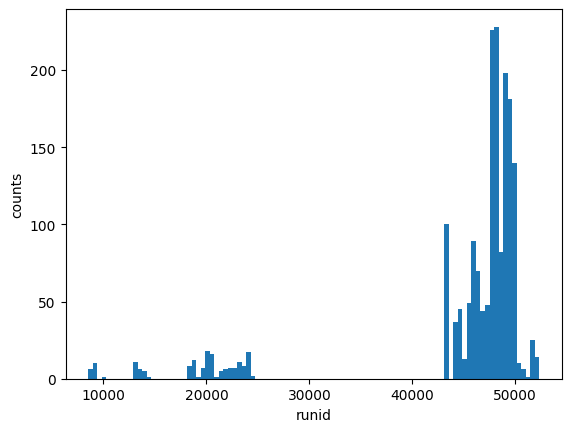

In [91]:
plt.hist(np.unique(overall['runid']).astype(int), bins=100)
plt.xlabel('runid')
plt.ylabel('counts')